# Introduction

The source code below, demonstrates the usage of CNN LeNet-5 architecture for all classes.

# Runtime req

Install appropriate run time and prepare the dataset.

In [ ]:
!pip install -q torch
!pip install -q matplotlib
!pip install -q visualkeras
!unzip -q "/content/drive/MyDrive/colab_notebooks/IITD-QML/EuroSAT_RGB.zip"

replace EuroSAT_RGB/Forest/Forest_864.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


Configure runtime to make sure that the imports are working well.

In [ ]:
import sys
import numpy as np
import random
import glob
import os
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, Flatten, MaxPool2D, BatchNormalization, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append('/content/drive/MyDrive/colab_notebooks/IITD-QML/')
dataset_root_path = '/content/EuroSAT_RGB'

Discover the root path for all the classes present in folder hierarchy.

# Classical CNN


In [ ]:
kernel_size = 3
stride = 1

model = Sequential()
model.add(Conv2D(16, kernel_size=kernel_size, strides=stride, activation='relu', padding='same', input_shape = (64,64,3)))
model.add(AveragePooling2D())
model.add(Conv2D(32, kernel_size=kernel_size, strides=stride, activation='relu', padding='valid'))
model.add(AveragePooling2D())
model.add(Conv2D(64, kernel_size=kernel_size, strides=stride, activation='relu', padding='valid'))
model.add(AveragePooling2D())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=SGD(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 average_pooling2d_3 (Averag  (None, 32, 32, 16)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        4640      
                                                                 
 average_pooling2d_4 (Averag  (None, 15, 15, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 average_pooling2d_5 (Averag  (None, 6, 6, 64)        

In [ ]:
import glob
import os
import numpy as np
import random

class DatasetHandler:
    def __init__(self, ds_root_path):
        print ('Datahandler init -> ', ds_root_path)
        self.dataset_path = ds_root_path
        self.classes = glob.glob(os.path.join(ds_root_path, '*'))
        self.classes_dict = {}
        for c, i in zip(self.classes, range(len(self.classes))):
          self.classes_dict[c] = i

    def print_classes(self):
        print('Classes in the path: ')
        for i,c in enumerate(self.classes):
            print(i, ' ->', c)

    def load_paths_labels(self, root, classes):
        imgs_path = []
        imgs_label = []

        for clss in self.classes:
            for path in glob.glob(os.path.join(root, clss+'/*')):
              imgs_path.append(path)
              imgs_label.append(self.classes_dict[clss])

        dataset = list(zip(imgs_path, imgs_label))
        random.shuffle(dataset)
        paths, labels = zip(*dataset)
        return np.array(paths), np.array(labels)

    # Split the dataset into training and validation dataset
    def train_validation_split(self, images, labels, split_factor = 0.2):
        val_size = int(len(images)*split_factor)
        train_size = int(len(images) - val_size)
        return images[0:train_size], labels[0:train_size, ...], images[train_size:train_size+val_size], labels[train_size:train_size+val_size, ...]

    # Data genertor: given images paths and images labels yield a batch of images and labels
    def cnn_data_loader(self, imgs_path, imgs_label, batch_size = 16, img_shape = (64, 64, 3), n_classes = 2):
        # Initialize the vectors to be yield
        batch_in = np.zeros((batch_size, img_shape[0], img_shape[1], img_shape[2]))
        batch_out = np.zeros((batch_size, n_classes))
        # Repeat until the generator will be stopped
        while True:
            # Load a batch of images and labels
            for i in range(batch_size):
                # Select a random image and labels from the dataset
                index = random.randint(0, len(imgs_path)-1)
                # Fill the vectors with images and labels
                batch_in[i, ...] = plt.imread(imgs_path[index])/255.0
                l = np.zeros((n_classes))
                l[imgs_label[index]] = 1
                batch_out[i, ...] = l

            # Yield/Return the image and labeld vectors
            yield batch_in, batch_out


In [ ]:
handler = DatasetHandler(dataset_root_path)
imgs_path, imgs_label = handler.load_paths_labels(dataset_root_path, handler.classes)
print('Dataset images:', len(imgs_path), 'Dataset labels:', len(imgs_label))
print('Dataset sample ->', imgs_path[0], imgs_label[0])

Datahandler init ->  /content/EuroSAT_RGB
Dataset images: 27000 Dataset labels: 27000
Dataset sample -> /content/EuroSAT_RGB/AnnualCrop/AnnualCrop_641.jpg 8


In [ ]:
train_imgs, train_labels, val_images, val_labels = handler.train_validation_split(imgs_path, imgs_label, split_factor=0.2)
print('X_train shape:', train_imgs.shape, 'Y_train shape:', train_labels.shape)
print('  X_val shape: ', val_images.shape, '  Y_val shape: ', val_labels.shape)

X_train shape: (21600,) Y_train shape: (21600,)
  X_val shape:  (5400,)   Y_val shape:  (5400,)


In [ ]:
def plotDataset(images, labels, classes, columns, rows):
    fig, axes = plt.subplots(nrows = rows, ncols = columns, figsize = (columns*4,rows*4))
    for x in range(columns):
        for y in range(rows):
            index = random.randint(0, len(images)-1)

            axes[y,x].imshow(plt.imread(images[index]))
            axes[y,x].set_title('Label: ' + str(labels[index]) +
                                '\n Class: ' + classes[labels[index]].split('/')[-1])
            axes[y,x].axis(False)

    plt.show()

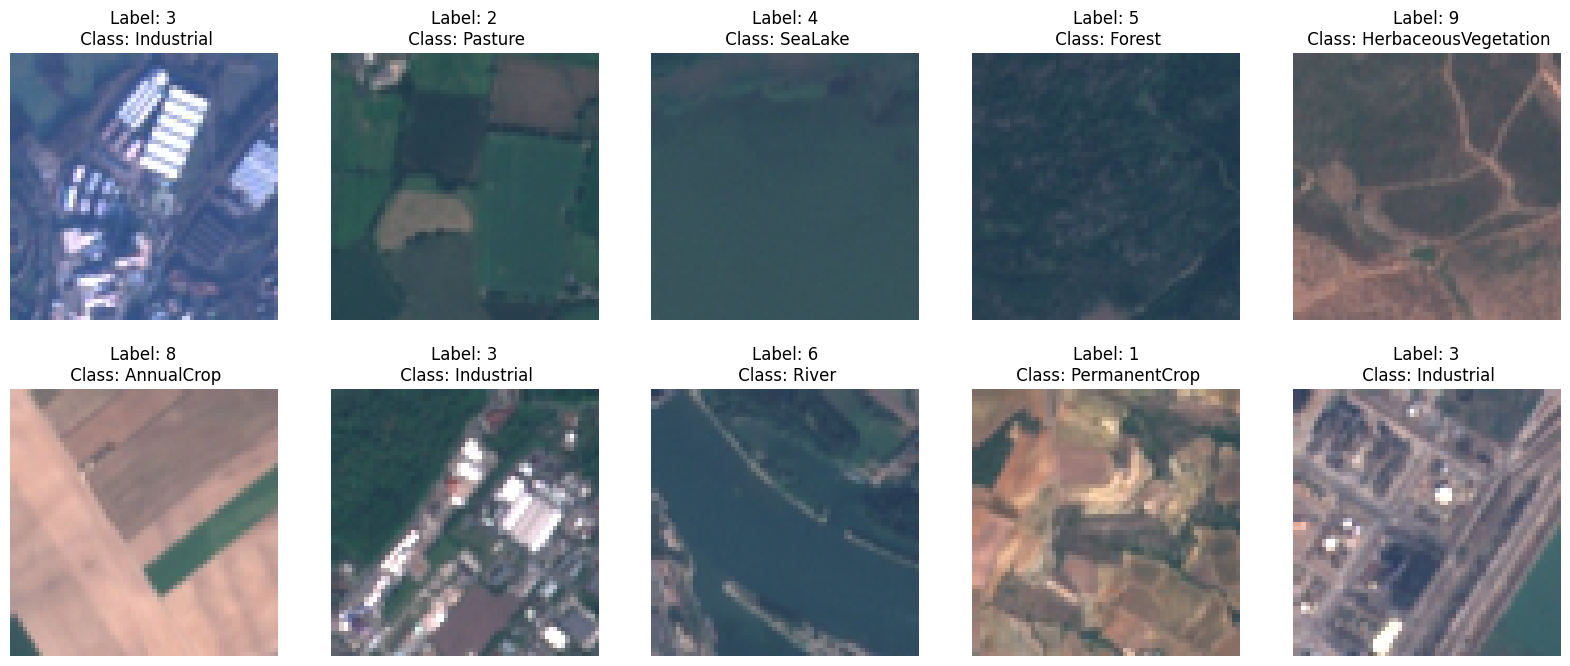

In [ ]:
plotDataset(train_imgs, train_labels, handler.classes, columns = 5, rows = 2)

In [ ]:
batch_size = 1
epochs = 100

train_gen = handler.cnn_data_loader(train_imgs, train_labels, batch_size=batch_size, img_shape=(64,64,3), n_classes=10)
val_gen = handler.cnn_data_loader(val_images, val_labels, batch_size=batch_size, img_shape=(64,64,3), n_classes=10)

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

history = model.fit(train_gen,
                            steps_per_epoch = len(train_labels)//batch_size,
                            epochs = epochs,
                            validation_data = val_gen,
                            validation_steps = len(val_labels)//batch_size,
                            callbacks = [es])

Epoch 1/100
21600/21600 [==============================] - 133s 6ms/step - loss: 2.1933 - accuracy: 0.1796 - val_loss: 1.9402 - val_accuracy: 0.2563
Epoch 2/100
21600/21600 [==============================] - 127s 6ms/step - loss: 1.7761 - accuracy: 0.3183 - val_loss: 1.7150 - val_accuracy: 0.3400
Epoch 3/100
21600/21600 [==============================] - 131s 6ms/step - loss: 1.6627 - accuracy: 0.3745 - val_loss: 1.6308 - val_accuracy: 0.3944
Epoch 4/100
21600/21600 [==============================] - 127s 6ms/step - loss: 1.5676 - accuracy: 0.4181 - val_loss: 1.5550 - val_accuracy: 0.4083
Epoch 5/100
21600/21600 [==============================] - 124s 6ms/step - loss: 1.5064 - accuracy: 0.4418 - val_loss: 1.5364 - val_accuracy: 0.4361
Epoch 6/100
21600/21600 [==============================] - 133s 6ms/step - loss: 1.4469 - accuracy: 0.4658 - val_loss: 1.4792 - val_accuracy: 0.4459
Epoch 7/100
21600/21600 [==============================] - 131s 6ms/step - loss: 1.3995 - accuracy: 0.4915

In [ ]:
model.save(os.path.join('trained_models', 'CNN-all_classes.h5'))

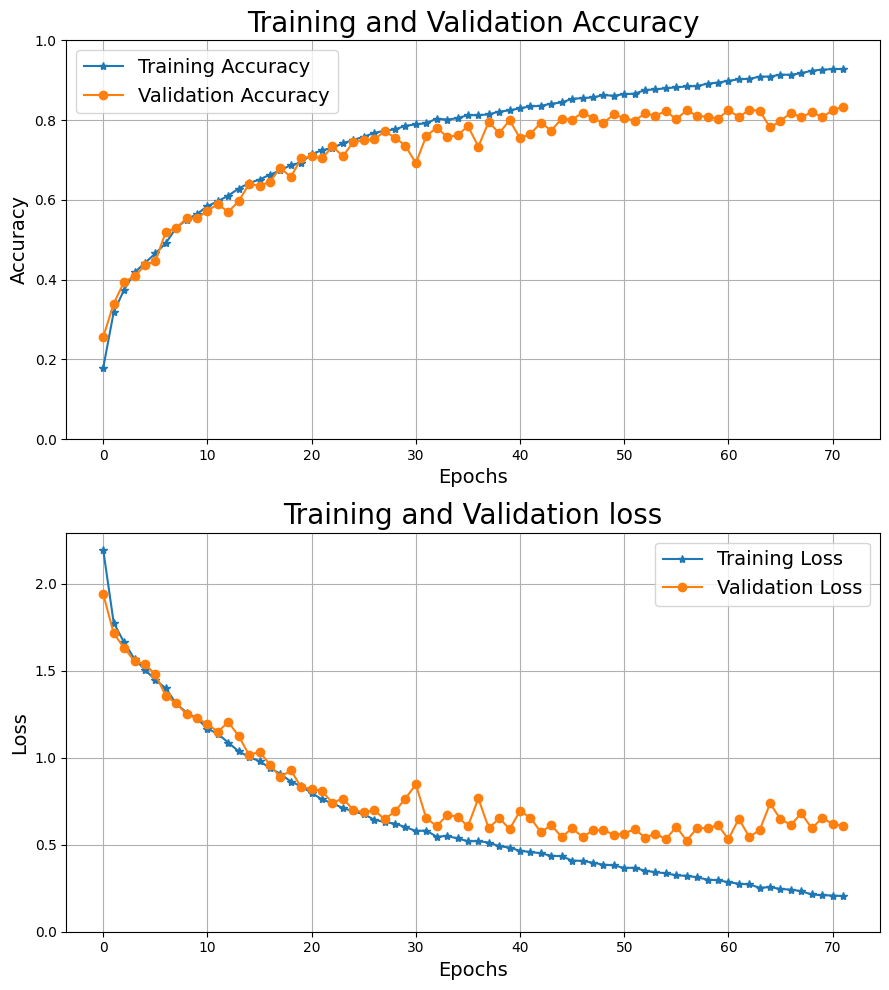

In [ ]:
def plotCNNhistory(history):
    x = np.arange(0, len(history.history['accuracy']))

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 10))

    axes[0].plot(x, history.history['accuracy'], '-*')
    axes[0].plot(x, history.history['val_accuracy'], '-o')
    axes[0].legend(['Training Accuracy', 'Validation Accuracy'], fontsize = 14)
    axes[0].set_title('Training and Validation Accuracy', fontsize=20)
    axes[0].set_xlabel('Epochs', fontsize = 14)
    axes[0].set_ylabel('Accuracy', fontsize = 14)
    axes[0].set_ylim([0,1])
    axes[0].grid()

    axes[1].plot(x, history.history['loss'], '-*')
    axes[1].plot(x, history.history['val_loss'], '-o')
    axes[1].legend(['Training Loss', 'Validation Loss'], fontsize = 14)
    axes[1].set_title('Training and Validation loss', fontsize = 20)
    axes[1].set_xlabel('Epochs', fontsize = 14)
    axes[1].set_ylabel('Loss', fontsize = 14)
    axes[1].set_ylim([0,None])
    axes[1].grid()

    fig.tight_layout()
    plt.show()

plotCNNhistory(history)

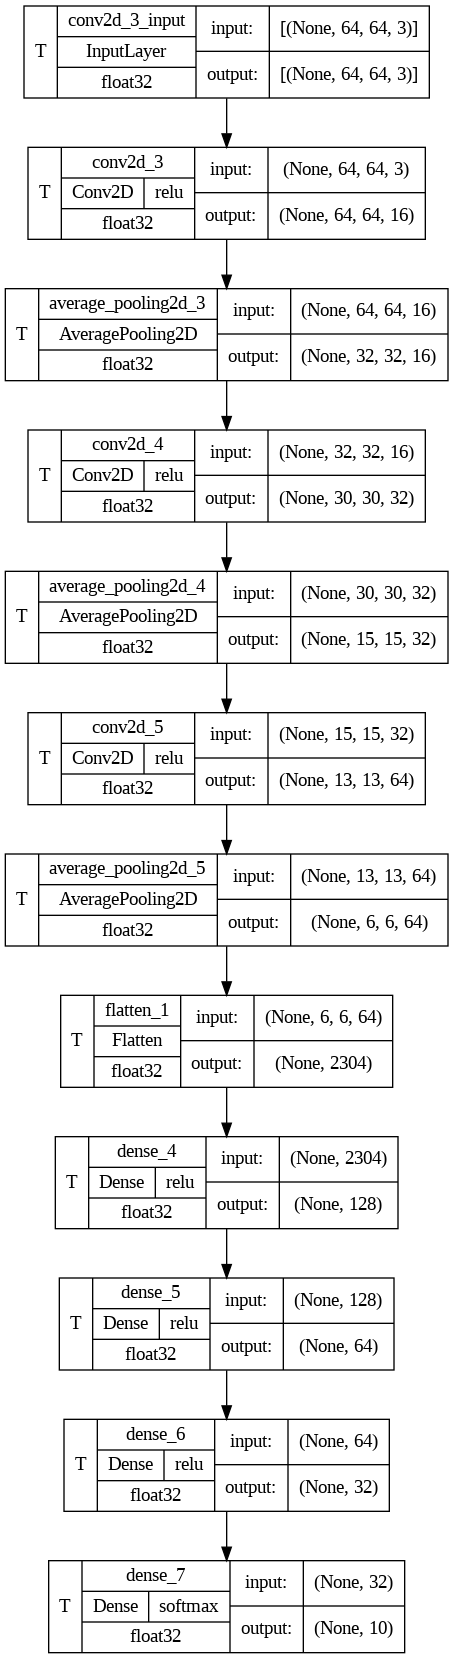

In [ ]:
import keras
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True,show_dtype=True, show_layer_names=True, show_layer_activations=True, show_trainable=True)


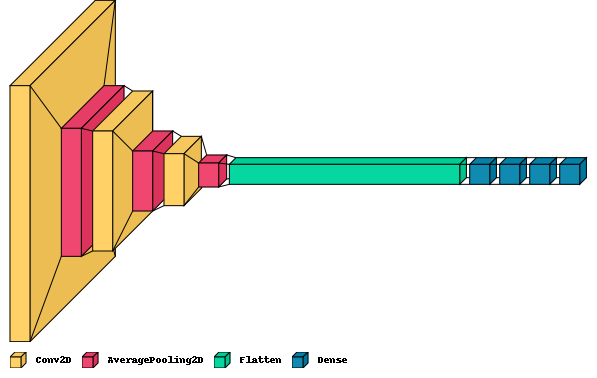

In [ ]:
import visualkeras
visualkeras.layered_view(model, legend=True,)